# Tamas Flesch Thesis - Linear regression step

## LMJU - UpGrad - DS

### Fifa 23 Ultimate Team player price prediction based on the player's attributes

Table of contents
1. Read data
2. Price distribution analysis
3. Test-Train Split
4. Feature Scaling
5. Feature Selection Using RFE
6. Building model using statsmodel, for the detailed statistics
7. Residual Analysis of the train data
8. Making Predictions Using the Final Model
9. Model evaluation

### 1. Read data

#### Imports

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing Pandas and NumPy
import pandas as pd, numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

import statsmodels.api as sm

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
# Importing all datasets
futbin_data = pd.read_csv("futbin.csv")
futbin_data.head()

,Name,Rating,Price,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
0,Pelé,98,3270000.0,5,4,95.0,96,93,96,60,76,3928,516,2513,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,Lionel Messi,98,4350000.0,4,4,93.0,98,97,99,40,77,5575,504,2469,169,67,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,Lionel Messi,98,4640000.0,4,4,94.0,97,96,99,40,79,701,505,2455,169,67,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Karim Benzema,97,1850000.0,4,5,92.0,97,90,94,45,90,4536,508,2449,185,81,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,Kylian Mbappé,97,9750000.0,5,4,99.0,96,88,98,44,87,3548,512,2455,182,73,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
futbin_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Columns: 105 entries, Name to Alt_Pos_3_missing
dtypes: float64(2), int64(102), object(1)
memory usage: 5.1+ MB


In [6]:
len(futbin_data[futbin_data.Price > 100000])

153

In [7]:
153/6397*100

2.3917461309989054

It seems to me that the Price are a little bit strange variable, there are some outliers in the data. 

We have only 153 players in the database which have a the Price greater than 100.000. Which is almost 2.5%.

I will create two models, one for the 'average' players and one for the extra expensive players. It will be interesting to compare what are the important features for the two groups.

In [8]:
average_players = futbin_data[futbin_data.Price < 100000]

In [9]:
average_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6243 entries, 30 to 6396
Columns: 105 entries, Name to Alt_Pos_3_missing
dtypes: float64(2), int64(102), object(1)
memory usage: 5.0+ MB


In [10]:
star_players = futbin_data[futbin_data.Price >= 100000]

In [11]:
star_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 566
Columns: 105 entries, Name to Alt_Pos_3_missing
dtypes: float64(2), int64(102), object(1)
memory usage: 127.5+ KB


### 2. Price distribution analysis

In [12]:
futbin_data.Price.describe()

count    6.397000e+03
mean     2.557498e+04
std      3.280786e+05
min      2.000000e+02
25%      2.000000e+02
50%      3.500000e+02
75%      1.000000e+03
max      1.500000e+07
Name: Price, dtype: float64

In [13]:
len(futbin_data[futbin_data.Price == 0])

0

<AxesSubplot:ylabel='Frequency'>

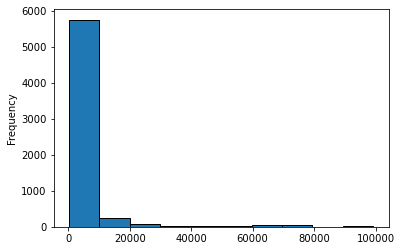

In [14]:
#plot distribution of values in price column
average_players['Price'].plot(kind='hist', edgecolor='black')

<AxesSubplot:ylabel='Frequency'>

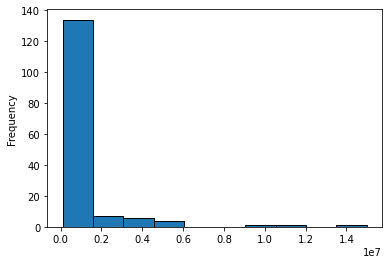

In [15]:
star_players['Price'].plot(kind='hist', edgecolor='black')

### 3. Test-Train Split

#### average

In [16]:
# Putting feature variable to X
X_avg = average_players.drop(['Name','Price'], axis=1)

X_avg.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
30,94,1,4,92.0,91,94,96,53,91,963,517,1092,187,85,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
46,93,4,5,90.0,90,81,85,43,84,753,473,2289,188,81,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
51,93,3,5,87.0,82,93,92,92,93,730,539,2545,189,83,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
54,93,5,4,94.0,90,90,94,69,78,391,515,2482,171,62,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
56,93,1,3,89.0,95,95,94,73,90,228,536,945,186,79,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [17]:
# Putting response variable to y
y_avg = average_players['Price']

y_avg.head()

30    61500.0
46    75000.0
51    70000.0
54    80000.0
56    38500.0
Name: Price, dtype: float64

In [18]:
# Splitting the average data into train and test
X_avg_train, X_avg_test, y_avg_train, y_avg_test = train_test_split(X_avg, y_avg, train_size=0.8, test_size=0.2, random_state=100)

#### star

In [19]:
# Putting feature variable to X
X_star = star_players.drop(['Name','Price'], axis=1)

X_star.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
0,98,5,4,95.0,96,93,96,60,76,3928,516,2513,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,98,4,4,93.0,98,97,99,40,77,5575,504,2469,169,67,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,98,4,4,94.0,97,96,99,40,79,701,505,2455,169,67,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,97,4,5,92.0,97,90,94,45,90,4536,508,2449,185,81,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,97,5,4,99.0,96,88,98,44,87,3548,512,2455,182,73,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [20]:
# Putting response variable to y
y_star = star_players['Price']

y_star.head()

0    3270000.0
1    4350000.0
2    4640000.0
3    1850000.0
4    9750000.0
Name: Price, dtype: float64

In [21]:
# Splitting the star data into train and test
X_star_train, X_star_test, y_star_train, y_star_test = train_test_split(X_star, y_star, train_size=0.8, test_size=0.2, random_state=100)

#### full data

In [22]:
# Putting feature variable to X
X_full = futbin_data.drop(['Name','Price'], axis=1)

X_full.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
0,98,5,4,95.0,96,93,96,60,76,3928,516,2513,173,70,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1,98,4,4,93.0,98,97,99,40,77,5575,504,2469,169,67,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,98,4,4,94.0,97,96,99,40,79,701,505,2455,169,67,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,97,4,5,92.0,97,90,94,45,90,4536,508,2449,185,81,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,97,5,4,99.0,96,88,98,44,87,3548,512,2455,182,73,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
# Putting response variable to y
y_full = futbin_data['Price']

y_full.head()

0    3270000.0
1    4350000.0
2    4640000.0
3    1850000.0
4    9750000.0
Name: Price, dtype: float64

In [24]:
# Splitting the full data into train and test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2, random_state=100)

### 4. Feature Scaling

In [25]:
# columns to be scaled
scale_columns = ['Rating','Skills_Star','Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
                'Dribbling / Reflexes', 'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Base_Stats',
                'Ingame_Stats', 'Height_in_cm', 'BodyType_Weight', 'Alt_Pos_Count']

#### average player scaling

In [26]:
scaler = StandardScaler()

X_avg_train[scale_columns] = scaler.fit_transform(X_avg_train[scale_columns])

X_avg_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
5917,-1.314890,-1.508137,-1.420183,-1.336225,-2.100084,-2.308421,-3.184101,0.375084,-0.259592,-0.150022,-2.131939,-1.121422,1.662681,2.224114,0,-1.152990,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3239,-0.116787,0.738101,-0.002555,-0.906434,0.326950,0.437884,0.159459,0.728813,0.232327,-0.150022,0.325111,0.600862,-0.249569,-0.044808,0,-0.020856,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4563,-0.476218,0.738101,-0.002555,0.898689,0.124697,0.071710,0.063929,-1.275649,-3.014338,-0.147539,-0.808912,-0.142973,-2.014722,-1.746500,0,1.111278,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1641,0.482264,1.486847,-1.420183,0.812730,0.326950,0.529427,1.401353,-1.157740,-2.227268,-0.090435,-0.157898,0.190286,-2.014722,-2.030116,0,-0.020856,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3696,-0.236598,0.738101,1.415074,0.640814,0.461785,0.437884,0.159459,0.139265,-0.357976,-0.150022,0.409113,0.430233,0.191720,0.238807,0,-0.020856,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


#### star player scaling

In [27]:
#scaler = StandardScaler()

X_star_train[scale_columns] = scaler.fit_transform(X_star_train[scale_columns])

X_star_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
160,-0.463246,-0.763577,-1.413577,0.225810,-0.026655,-0.005039,-1.267805,0.958672,0.370004,-0.521469,0.608205,0.587145,-1.826009,-0.866782,1,-0.391133,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
306,-1.149744,1.153157,1.282081,0.035573,0.196880,0.149898,0.427195,-1.119155,-2.583476,1.261731,-1.476643,-0.700583,-1.680165,-1.470828,0,1.955665,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
12,1.252998,0.194790,-0.065748,-0.344902,0.420415,1.079516,0.992195,1.194789,1.309747,-1.664257,2.161622,1.278983,0.799175,0.039288,0,0.782266,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
16,1.252998,1.153157,-0.065748,-0.535140,-1.889445,-1.244530,-2.397806,1.525352,0.638502,-0.186749,-0.659055,-0.700583,0.799175,1.247380,1,-1.564532,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
63,0.223251,0.194790,1.282081,-2.817990,0.494927,1.389389,-0.137805,0.061429,-0.435491,-0.254285,-0.086744,0.203351,0.069957,-0.715770,0,-0.391133,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


#### full data scaling

In [28]:
#scaler = StandardScaler()

X_full_train[scale_columns] = scaler.fit_transform(X_full_train[scale_columns])

X_full_train.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
2556,0.051639,-0.049719,-0.037041,-0.172038,0.471123,0.353793,0.187485,0.811246,0.393284,-0.178247,0.572846,0.582357,0.353851,-0.030789,0,1.098412,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5208,-0.831731,-0.049719,-0.037041,-2.784516,-1.943855,-1.902212,-2.439653,0.343847,0.393284,-0.176404,-1.986878,-0.904739,0.208089,0.675707,0,-0.033399,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2567,0.051639,-0.049719,-1.420548,-0.172038,-1.291159,0.180254,0.006303,0.869671,0.106190,-0.167187,-0.071970,0.203545,0.062327,-0.595987,0,-0.033399,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3412,-0.169203,0.687708,1.346465,0.586423,0.601662,-0.427132,0.096894,-1.350474,-1.042187,-0.178247,-0.423687,-0.072886,-0.374959,-0.454687,0,-0.033399,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2673,0.051639,-0.049719,-0.037041,0.249329,0.666932,0.353793,0.368666,-0.941500,-1.137885,-0.169030,-0.130589,0.190747,-0.666484,-0.454687,0,1.098412,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### 5. Feature Selection Using RFE

In [29]:
logreg = LogisticRegression()

#### average player rfe

In [30]:
%%time
rfe_avg = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_avg = rfe_avg.fit(X_avg_train, y_avg_train)

CPU times: total: 28min 37s
Wall time: 13min 40s


In [31]:
rfe_avg.support_

array([ True, False, False,  True,  True,  True, False,  True,  True,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False])

In [32]:
list(zip(X_avg_train.columns, rfe_avg.support_, rfe_avg.ranking_))

[('Rating', True, 1),
 ('Skills_Star', False, 13),
 ('Weak_Foot_Star', False, 10),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', True, 1),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 5),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', False, 34),
 ('Ingame_Stats', False, 11),
 ('Height_in_cm', False, 7),
 ('BodyType_Weight', False, 4),
 ('Club_Hero', True, 1),
 ('Alt_Pos_Count', False, 16),
 ('Main_Position_CB', False, 31),
 ('Main_Position_CDM', False, 46),
 ('Main_Position_CF', False, 58),
 ('Main_Position_CM', False, 20),
 ('Main_Position_GK', False, 70),
 ('Main_Position_LB', False, 33),
 ('Main_Position_LM', False, 42),
 ('Main_Position_LW', False, 39),
 ('Main_Position_LWB', False, 68),
 ('Main_Position_RB', False, 38),
 ('Main_Position_RM', False, 29),
 ('Main_Position_RW', False, 53),
 ('Main_Position_RWB', False, 67),
 ('Main_Position_ST', False, 26),
 ('Run_Style_Explosive', False, 3)

In [33]:
col_avg = X_avg_train.columns[rfe_avg.support_]

In [34]:
X_avg_train.columns[~rfe_avg.support_]

Index(['Skills_Star', 'Weak_Foot_Star', 'Dribbling / Reflexes', 'Base_Stats',
       'Ingame_Stats', 'Height_in_cm', 'BodyType_Weight', 'Alt_Pos_Count',
       'Main_Position_CB', 'Main_Position_CDM', 'Main_Position_CF',
       'Main_Position_CM', 'Main_Position_GK', 'Main_Position_LB',
       'Main_Position_LM', 'Main_Position_LW', 'Main_Position_LWB',
       'Main_Position_RB', 'Main_Position_RM', 'Main_Position_RW',
       'Main_Position_RWB', 'Main_Position_ST', 'Run_Style_Explosive',
       'Run_Style_Lengthy', 'Attack_Workrate_L', 'Defense_Workrate_L',
       'BodyType_Text_CR7', 'BodyType_Text_Courtois',
       'BodyType_Text_High & Average', 'BodyType_Text_High & Average+',
       'BodyType_Text_High & Lean', 'BodyType_Text_High & Stocky',
       'BodyType_Text_Lean', 'BodyType_Text_Messi', 'BodyType_Text_R9',
       'BodyType_Text_Ronaldinho', 'BodyType_Text_Salah',
       'BodyType_Text_Shaqiri', 'BodyType_Text_Short & Lean',
       'BodyType_Text_Short & Lean-', 'BodyType_Te

In [35]:
col_avg

Index(['Rating', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
       'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Club_Hero',
       'Attack_Workrate_M', 'Defense_Workrate_M', 'League_Cat_Ligue 1',
       'League_Cat_Other', 'Nation_Cat_Other', 'Alt_Pos_1_CM',
       'Alt_Pos_2_missing'],
      dtype='object')

#### star player rfe

In [36]:
%%time
rfe_star = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_star = rfe_star.fit(X_star_train, y_star_train)

CPU times: total: 28.1 s
Wall time: 13 s


In [37]:
rfe_star.support_

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [38]:
list(zip(X_star_train.columns, rfe_star.support_, rfe_star.ranking_))

[('Rating', True, 1),
 ('Skills_Star', True, 1),
 ('Weak_Foot_Star', True, 1),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', True, 1),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 4),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', True, 1),
 ('Ingame_Stats', False, 9),
 ('Height_in_cm', True, 1),
 ('BodyType_Weight', True, 1),
 ('Club_Hero', False, 2),
 ('Alt_Pos_Count', True, 1),
 ('Main_Position_CB', False, 46),
 ('Main_Position_CDM', False, 64),
 ('Main_Position_CF', False, 18),
 ('Main_Position_CM', False, 22),
 ('Main_Position_GK', False, 74),
 ('Main_Position_LB', False, 24),
 ('Main_Position_LM', False, 61),
 ('Main_Position_LW', False, 23),
 ('Main_Position_LWB', False, 57),
 ('Main_Position_RB', False, 48),
 ('Main_Position_RM', False, 60),
 ('Main_Position_RW', False, 37),
 ('Main_Position_RWB', False, 75),
 ('Main_Position_ST', False, 13),
 ('Run_Style_Explosive', False, 12),
 ('Run_

In [39]:
col_star = X_star_train.columns[rfe_star.support_]

In [40]:
X_star_train.columns[~rfe_star.support_]

Index(['Dribbling / Reflexes', 'Ingame_Stats', 'Club_Hero', 'Main_Position_CB',
       'Main_Position_CDM', 'Main_Position_CF', 'Main_Position_CM',
       'Main_Position_GK', 'Main_Position_LB', 'Main_Position_LM',
       'Main_Position_LW', 'Main_Position_LWB', 'Main_Position_RB',
       'Main_Position_RM', 'Main_Position_RW', 'Main_Position_RWB',
       'Main_Position_ST', 'Run_Style_Explosive', 'Run_Style_Lengthy',
       'Attack_Workrate_L', 'Attack_Workrate_M', 'Defense_Workrate_L',
       'BodyType_Text_CR7', 'BodyType_Text_Courtois',
       'BodyType_Text_High & Average', 'BodyType_Text_High & Average+',
       'BodyType_Text_High & Lean', 'BodyType_Text_High & Stocky',
       'BodyType_Text_Lean', 'BodyType_Text_Messi', 'BodyType_Text_R9',
       'BodyType_Text_Ronaldinho', 'BodyType_Text_Salah',
       'BodyType_Text_Shaqiri', 'BodyType_Text_Short & Lean',
       'BodyType_Text_Short & Lean-', 'BodyType_Text_Short and Balanced',
       'BodyType_Text_Stocky', 'BodyType_Text_Un

In [41]:
col_star

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Shooting / Handling', 'Passing / Kicking', 'Defense / Speed',
       'Physical / Positioning', 'Popularity', 'Base_Stats', 'Height_in_cm',
       'BodyType_Weight', 'Alt_Pos_Count', 'Defense_Workrate_M',
       'Nation_Cat_Other'],
      dtype='object')

#### full data

In [42]:
%%time
rfe_full = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe_full = rfe_star.fit(X_full_train, y_full_train)

CPU times: total: 37min 19s
Wall time: 17min 26s


it is a very resource heavy operation, took almost 19 mins to run on a pc

In [43]:
rfe_full.support_

array([ True, False,  True,  True,  True,  True, False,  True,  True,
        True, False, False,  True, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [44]:
list(zip(X_full_train.columns, rfe_full.support_, rfe_full.ranking_))

[('Rating', True, 1),
 ('Skills_Star', False, 8),
 ('Weak_Foot_Star', True, 1),
 ('Pace / Diving', True, 1),
 ('Shooting / Handling', True, 1),
 ('Passing / Kicking', True, 1),
 ('Dribbling / Reflexes', False, 6),
 ('Defense / Speed', True, 1),
 ('Physical / Positioning', True, 1),
 ('Popularity', True, 1),
 ('Base_Stats', False, 31),
 ('Ingame_Stats', False, 14),
 ('Height_in_cm', True, 1),
 ('BodyType_Weight', False, 3),
 ('Club_Hero', True, 1),
 ('Alt_Pos_Count', True, 1),
 ('Main_Position_CB', False, 36),
 ('Main_Position_CDM', False, 40),
 ('Main_Position_CF', False, 52),
 ('Main_Position_CM', False, 22),
 ('Main_Position_GK', False, 69),
 ('Main_Position_LB', False, 34),
 ('Main_Position_LM', False, 46),
 ('Main_Position_LW', False, 37),
 ('Main_Position_LWB', False, 68),
 ('Main_Position_RB', False, 47),
 ('Main_Position_RM', False, 32),
 ('Main_Position_RW', False, 49),
 ('Main_Position_RWB', False, 65),
 ('Main_Position_ST', False, 15),
 ('Run_Style_Explosive', False, 12),
 ('

In [45]:
col_full = X_full_train.columns[rfe_full.support_]

In [46]:
X_full_train.columns[~rfe_full.support_]

Index(['Skills_Star', 'Dribbling / Reflexes', 'Base_Stats', 'Ingame_Stats',
       'BodyType_Weight', 'Main_Position_CB', 'Main_Position_CDM',
       'Main_Position_CF', 'Main_Position_CM', 'Main_Position_GK',
       'Main_Position_LB', 'Main_Position_LM', 'Main_Position_LW',
       'Main_Position_LWB', 'Main_Position_RB', 'Main_Position_RM',
       'Main_Position_RW', 'Main_Position_RWB', 'Main_Position_ST',
       'Run_Style_Explosive', 'Run_Style_Lengthy', 'Attack_Workrate_L',
       'Attack_Workrate_M', 'Defense_Workrate_L', 'BodyType_Text_CR7',
       'BodyType_Text_Courtois', 'BodyType_Text_High & Average',
       'BodyType_Text_High & Average+', 'BodyType_Text_High & Lean',
       'BodyType_Text_High & Stocky', 'BodyType_Text_Lean',
       'BodyType_Text_Messi', 'BodyType_Text_R9', 'BodyType_Text_Ronaldinho',
       'BodyType_Text_Salah', 'BodyType_Text_Shaqiri',
       'BodyType_Text_Short & Lean', 'BodyType_Text_Short & Lean-',
       'BodyType_Text_Short and Balanced', 'BodyT

In [47]:
col_full

Index(['Rating', 'Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'Club_Hero', 'Alt_Pos_Count',
       'Defense_Workrate_M', 'BodyType_Text_Unique', 'League_Cat_Ligue 1',
       'Nation_Cat_Other'],
      dtype='object')

#### After RFE

As a first step, I run an RFE, automatic feature selection, in the dataset, we have 103 columns (105, minus the name and the price). From these I wanted to select the 15 most important ones.

In [48]:
col_avg

Index(['Rating', 'Pace / Diving', 'Shooting / Handling', 'Passing / Kicking',
       'Defense / Speed', 'Physical / Positioning', 'Popularity', 'Club_Hero',
       'Attack_Workrate_M', 'Defense_Workrate_M', 'League_Cat_Ligue 1',
       'League_Cat_Other', 'Nation_Cat_Other', 'Alt_Pos_1_CM',
       'Alt_Pos_2_missing'],
      dtype='object')

In [49]:
col_star

Index(['Rating', 'Skills_Star', 'Weak_Foot_Star', 'Pace / Diving',
       'Shooting / Handling', 'Passing / Kicking', 'Defense / Speed',
       'Physical / Positioning', 'Popularity', 'Base_Stats', 'Height_in_cm',
       'BodyType_Weight', 'Alt_Pos_Count', 'Defense_Workrate_M',
       'Nation_Cat_Other'],
      dtype='object')

In [50]:
col_full

Index(['Rating', 'Weak_Foot_Star', 'Pace / Diving', 'Shooting / Handling',
       'Passing / Kicking', 'Defense / Speed', 'Physical / Positioning',
       'Popularity', 'Height_in_cm', 'Club_Hero', 'Alt_Pos_Count',
       'Defense_Workrate_M', 'BodyType_Text_Unique', 'League_Cat_Ligue 1',
       'Nation_Cat_Other'],
      dtype='object')

### 6. Building model using statsmodel, for the detailed statistics

#### first I build a model for the average players, and then optimizing it by removeing the least significant features (iterativly)

In [51]:
def linear_model_avg(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_avg_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_avg_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a

In [52]:
#linear_model_avg(col_avg)

Nation_Cat_Other is the least significant feature (0.770 P>|t|). -> drop the feature

In [53]:
col_avg = col_avg.drop('Nation_Cat_Other')

In [54]:
#col_avg

In [55]:
#linear_model_avg(col_avg)

In [56]:
col_avg = col_avg.drop('Defense / Speed')

In [57]:
#linear_model_avg(col_avg)

In [58]:
col_avg = col_avg.drop('Shooting / Handling')

In [59]:
#linear_model_avg(col_avg)

In [60]:
col_avg = col_avg.drop('Alt_Pos_1_CM')

In [61]:
#linear_model_avg(col_avg)

In [62]:
col_avg = col_avg.drop('Alt_Pos_2_missing')

In [63]:
#linear_model_avg(col_avg)

In [64]:
col_avg = col_avg.drop('Defense_Workrate_M')

In [65]:
#linear_model_avg(col_avg)

In [66]:
col_avg = col_avg.drop('League_Cat_Other')

In [67]:
#linear_model_avg(col_avg)

In [68]:
col_avg = col_avg.drop('Physical / Positioning')

In [69]:
#linear_model_avg(col_avg)

In [70]:
col_avg = col_avg.drop('Passing / Kicking')

keep dropping the least significant column from the table

In [71]:
linear_model_avg(col_avg)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     1201.
Date:                Fri, 25 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:18:31   Log-Likelihood:                -51357.
No. Observations:                4994   AIC:                         1.027e+05
Df Residuals:                    4987   BIC:                         1.028e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               2238.0164    168

#### let's try the same for the star players

In [72]:
def linear_model_star(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_star_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_star_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

In [73]:
#linear_model_star(col_star)

In [74]:
col_star = col_star.drop('Physical / Positioning')

In [75]:
#linear_model_star(col_star)

In [76]:
col_star = col_star.drop('BodyType_Weight')

In [77]:
#linear_model_star(col_star)

In [78]:
col_star = col_star.drop('Alt_Pos_Count')

In [79]:
#linear_model_star(col_star)

In [80]:
col_star = col_star.drop('Pace / Diving')

In [81]:
#linear_model_star(col_star)

In [82]:
col_star = col_star.drop('Weak_Foot_Star')

In [83]:
#linear_model_star(col_star)

In [84]:
col_star = col_star.drop('Nation_Cat_Other')

In [85]:
#linear_model_star(col_star)

In [86]:
col_star = col_star.drop('Height_in_cm')

In [87]:
#linear_model_star(col_star)

In [88]:
col_star = col_star.drop('Defense_Workrate_M')

In [89]:
#linear_model_star(col_star)

In [90]:
col_star = col_star.drop('Popularity')

In [91]:
#linear_model_star(col_star)

In [92]:
col_star = col_star.drop('Shooting / Handling')

In [93]:
#linear_model_star(col_star)

In [94]:
col_star = col_star.drop('Base_Stats')

In [95]:
#linear_model_star(col_star)

In [96]:
col_star = col_star.drop('Defense / Speed')

In [97]:
#linear_model_star(col_star)

In [98]:
col_star = col_star.drop('Passing / Kicking')

In [99]:
linear_model_star(col_star)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     22.67
Date:                Fri, 25 Aug 2023   Prob (F-statistic):           4.46e-09
Time:                        10:18:32   Log-Likelihood:                -1941.7
No. Observations:                 123   AIC:                             3889.
Df Residuals:                     120   BIC:                             3898.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        9.507e+05   1.59e+05      5.996      

#### checking the same on the original database

In [100]:
def linear_model_full(columns):
    # Creating X_train dataframe with RFE selected variables
    rfe = X_full_train[columns]
    # Adding a constant variable   
    rfe = sm.add_constant(rfe)
    # Running the linear model
    lm = sm.OLS(y_full_train,rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())

In [101]:
#linear_model_full(col_full)

In [102]:
col_full = col_full.drop('Pace / Diving')

In [103]:
#linear_model_full(col_full)

In [104]:
col_full = col_full.drop('Height_in_cm')

In [105]:
#linear_model_full(col_full)

In [106]:
col_full = col_full.drop('Nation_Cat_Other')

In [107]:
#linear_model_full(col_full)

In [108]:
col_full = col_full.drop('Defense_Workrate_M')

In [109]:
#linear_model_full(col_full)

In [110]:
col_full = col_full.drop('Rating')

In [111]:
#linear_model_full(col_full)

In [112]:
col_full = col_full.drop('Alt_Pos_Count')

In [113]:
#linear_model_full(col_full)

In [114]:
col_full = col_full.drop('Shooting / Handling')

In [115]:
#linear_model_full(col_full)

In [116]:
col_full = col_full.drop('Passing / Kicking')

In [117]:
linear_model_full(col_full)

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     84.05
Date:                Fri, 25 Aug 2023   Prob (F-statistic):          4.10e-116
Time:                        10:18:32   Log-Likelihood:                -72195.
No. Observations:                5117   AIC:                         1.444e+05
Df Residuals:                    5109   BIC:                         1.445e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   8585

### 7. Residual Analysis of the train data (avg)

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [119]:
rfe = X_avg_train[col_avg]
# Adding a constant variable   
rfe = sm.add_constant(rfe)
# Running the linear model
lm = sm.OLS(y_avg_train,rfe).fit()

In [120]:
y_avg_train_price = lm.predict(rfe)

Text(0.5, 0, 'Errors')

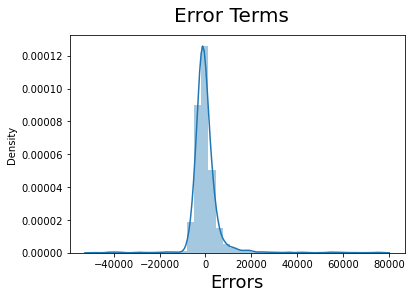

In [121]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_avg_train - y_avg_train_price), bins = 40)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### 8. Making Predictions Using the Final Model

In [122]:
X_avg_test[scale_columns] = scaler.transform(X_avg_test[scale_columns])

X_avg_test.head()

,Rating,Skills_Star,Weak_Foot_Star,Pace / Diving,Shooting / Handling,Passing / Kicking,Dribbling / Reflexes,Defense / Speed,Physical / Positioning,Popularity,Base_Stats,Ingame_Stats,Height_in_cm,BodyType_Weight,Club_Hero,Alt_Pos_Count,Main_Position_CB,Main_Position_CDM,Main_Position_CF,Main_Position_CM,Main_Position_GK,Main_Position_LB,Main_Position_LM,Main_Position_LW,Main_Position_LWB,Main_Position_RB,Main_Position_RM,Main_Position_RW,Main_Position_RWB,Main_Position_ST,Run_Style_Explosive,Run_Style_Lengthy,Attack_Workrate_L,Attack_Workrate_M,Defense_Workrate_L,Defense_Workrate_M,BodyType_Text_CR7,BodyType_Text_Courtois,BodyType_Text_High & Average,BodyType_Text_High & Average+,BodyType_Text_High & Lean,BodyType_Text_High & Stocky,BodyType_Text_Lean,BodyType_Text_Messi,BodyType_Text_R9,BodyType_Text_Ronaldinho,BodyType_Text_Salah,BodyType_Text_Shaqiri,BodyType_Text_Short & Lean,BodyType_Text_Short & Lean-,BodyType_Text_Short and Balanced,BodyType_Text_Stocky,BodyType_Text_Unique,League_Cat_Icons,League_Cat_LaLiga Santander,League_Cat_Ligue 1,League_Cat_Major League Soccer,League_Cat_Other,League_Cat_Premier League,League_Cat_Serie A TIM,Nation_Cat_England,Nation_Cat_France,Nation_Cat_Germany,Nation_Cat_Other,Nation_Cat_Spain,Alt_Pos_1_CB,Alt_Pos_1_CDM,Alt_Pos_1_CF,Alt_Pos_1_CM,Alt_Pos_1_LB,Alt_Pos_1_LM,Alt_Pos_1_LW,Alt_Pos_1_LWB,Alt_Pos_1_RB,Alt_Pos_1_RM,Alt_Pos_1_RW,Alt_Pos_1_RWB,Alt_Pos_1_ST,Alt_Pos_1_missing,Alt_Pos_2_CB,Alt_Pos_2_CDM,Alt_Pos_2_CF,Alt_Pos_2_CM,Alt_Pos_2_LB,Alt_Pos_2_LM,Alt_Pos_2_LW,Alt_Pos_2_LWB,Alt_Pos_2_RB,Alt_Pos_2_RM,Alt_Pos_2_RW,Alt_Pos_2_ST,Alt_Pos_2_missing,Alt_Pos_3_CDM,Alt_Pos_3_CF,Alt_Pos_3_CM,Alt_Pos_3_LB,Alt_Pos_3_LM,Alt_Pos_3_LW,Alt_Pos_3_LWB,Alt_Pos_3_RM,Alt_Pos_3_RW,Alt_Pos_3_ST,Alt_Pos_3_missing
5306,-0.831731,-0.049719,1.346465,0.080782,-1.030080,-0.253593,-0.809016,0.226997,-0.085206,-0.176404,-0.462767,-0.170149,-0.958008,-0.454687,0,1.098412,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2583,0.051639,0.687708,-0.037041,0.417876,0.536393,0.614101,0.368666,0.928095,0.106190,-0.174560,0.807325,0.858788,-0.812246,-0.737286,0,-0.033399,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3561,-0.279625,-1.524573,-0.037041,-0.509132,0.797471,0.180254,0.187485,0.168572,-0.946489,-0.176404,0.064810,0.321284,-0.374959,-0.030789,0,-1.165211,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
353,2.039222,0.687708,1.346465,1.850525,1.972326,1.915642,1.636940,-0.590951,1.063170,2.384072,1.823399,1.409091,0.353851,-0.313388,0,1.098412,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5499,-0.942152,0.687708,-0.037041,-0.424859,0.079505,-1.555134,-0.627834,-1.759448,-1.616375,-0.174560,-1.478841,-0.720451,-1.395295,-0.454687,0,2.230224,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


In [123]:
# Adding constant variable to test dataframe
rfe = X_avg_test[col_avg]
rfe = sm.add_constant(rfe)

In [124]:
# Making predictions

y_avg_pred = lm.predict(rfe)

### 9. Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_avg_pred')

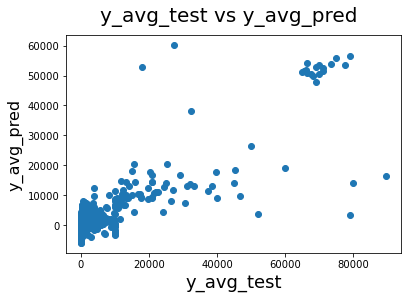

In [125]:
# Plotting y_avg_test and y_avg_pred to understand the spread

fig = plt.figure()
plt.scatter(y_avg_test, y_avg_pred)
fig.suptitle('y_avg_test vs y_avg_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_avg_test', fontsize = 18)                              # X-label
plt.ylabel('y_avg_pred', fontsize = 16)    

In [126]:
from sklearn.metrics import r2_score

In [127]:
r2_score(y_avg_test, y_avg_pred)

0.6515615396141419